In [23]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np 
from torch.utils.data import Dataset, DataLoader
import os 
from torchmetrics.classification.accuracy import BinaryAccuracy
import pandas as pd 
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
import pickle 
import torchvision.transforms as TT 


In [24]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])



In [25]:
BASE_IMAGE_DIR= "ReinforcementImages"


In [26]:
from SegmentationAI import Decider 

dec = Decider() 


In [27]:
# TODO - Load images with their target values? 
resize_factor = T.Resize((128,128), antialias=True)
def load_and_clean(img_path):
    
    img = read_image(img_path,ImageReadMode.RGB)
    
    img = resize_factor.forward(img)  
    img = TT.ConvertImageDtype(torch.float32).forward(img) 

#     img = img.float() 
    img = img.unsqueeze(0) 
    
    img = dec.image_map(img) 
#     show(img) 
    
    return img 
possible_moves = ['up','left','right']

data_points = [] 

categorical_variables = {}
c_v_idx = 0 

for file in os.listdir(BASE_IMAGE_DIR):
    moves = set(file.split("_")).intersection(possible_moves) 
    formatted = [] 
    for m in possible_moves:
        if m in moves:
            formatted.append(m) 
    
    moves = " ".join(formatted)  
    if moves not in categorical_variables:
        categorical_variables[moves] = c_v_idx 
        c_v_idx += 1 
    moves = categorical_variables[moves] 
     
        
    img = load_and_clean(f"{BASE_IMAGE_DIR}/{file}")  
    
    data_points.append((img, moves))     

In [28]:
print(categorical_variables) 

{'up': 0, 'up left': 1, 'right': 2, 'up right': 3, 'left': 4, '': 5}


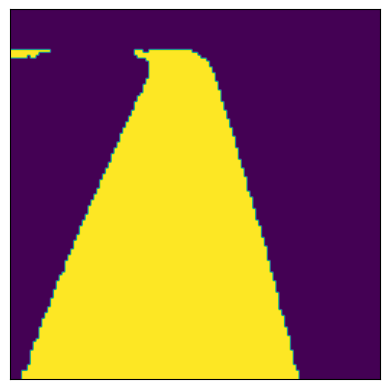

In [29]:
show(data_points[0][0].squeeze(0)) 

In [30]:
class CDS(Dataset):
    def __init__(self, lof_points):
        self.lof_points = lof_points 
    def __len__(self):
        return len(self.lof_points) 
    
    def __getitem__(self, idx):
        pair = self.lof_points[idx] 
        return pair 



dl_points = CDS(data_points) 

train_size = int(0.75 * len(dl_points))
test_size = len(dl_points) - train_size

splits = torch.utils.data.random_split(dl_points, [train_size, test_size])     
train = splits[0] 
val = splits[1]
 

In [33]:

def highest_idx(vals):
    m = None
    out_idx = None 
    
    for idx, val in enumerate(vals):
        if m is None or val > m:
            m = val 
            out_idx = idx
    return out_idx 

class ImitationNN(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
#         self.layers = nn.Sequential(
#             nn.Linear(in_features=128*128, out_features=len(categorical_variables)), 
#         )
        self.layers = nn.Sequential(
            nn.Linear(in_features=128*128, out_features=64*64), 
            nn.Linear(in_features=64*64, out_features=32*32), 
            nn.Linear(in_features=32*32, out_features=len(categorical_variables)), 
            nn.Softmax(), 
        )
        
        self.loss = nn.CrossEntropyLoss()
        
        
        
          
    def configure_optimizers(self):

        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        return optimizer 
    
    def training_step(self, batch, batch_idx):
        feats, target = batch 
        
        pred = self.forward(feats) 
        
        pred_idx = highest_idx(pred) 
        
        labels = torch.Tensor(np.zeros(len(pred)))
        labels[target] = 1 
        
        loss = self.loss(pred, labels)
        self.log("train_loss", loss, prog_bar=True)
        
        return loss 
          
        
    
    def validation_step(self, batch, batch_idx):
        feats, target = batch 
        pred = self.forward(feats) 
        
        pred_idx = highest_idx(pred) 
        
        labels = torch.Tensor(np.zeros(len(pred)))
        labels[target] = 1 
        
        loss = self.loss(pred, labels)
        self.log("val_loss", loss, prog_bar=True)
        
        return loss 
          

    def forward(self, x):
        flatten = torch.flatten(x) 
        return self.layers(flatten)  

print(train[0][0].shape)
model = ImitationNN() 


torch.Size([1, 128, 128])


In [34]:
trainer = pl.Trainer(max_epochs=5,
                     logger=pl.loggers.TensorBoardLogger('./voc'),
                     log_every_n_steps=1) 
trainer.fit(model=model, train_dataloaders=train, val_dataloaders=val) 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type             | Params
--------------------------------------------
0 | layers | Sequential       | 71.3 M
1 | loss   | CrossEntropyLoss | 0     
--------------------------------------------
71.3 M    Trainable params
0         Non-trainable params
71.3 M    Total params
285.258   Total estimated model params size (MB)


/Users/ryankennedy/opt/anaconda3/envs/robotics/lib/python3.8/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1453/1453 [02:56<00:00,  8.25it/s, v_num=103, train_loss=1.040]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   7%|██████████▎                                                                                                                                | 36/485 [00:00<00:10, 42.18it/s]


Validation DataLoader 0:  15%|█████████████████████▍                                                                                                                     | 75/485 [00:01<00:09, 43.83it/s]


Validation DataLoader 0:  24%|████████████████████████████████▍                                                                                                         | 114/485 [00:02<00:08, 45.64it/s]


Validation DataLoader 0:  32%|███████████████████████████████████████████▌                                                                                              | 153/485 [00:03<00:07, 46.37it/s]


Validation DataLoader 0:  40%|██████████████████████████████████████████████████████▋                                                                                   | 192/485 [00:04<00:06, 46.68it/s]


Validation DataLoader 0:  48%|█████████████████████████████████████████████████████████████████▋                                                                        | 231/485 [00:05<00:05, 46.18it/s]


Validation DataLoader 0:  56%|████████████████████████████████████████████████████████████████████████████▊                                                             | 270/485 [00:05<00:04, 46.23it/s]


Validation DataLoader 0:  64%|███████████████████████████████████████████████████████████████████████████████████████▉                                                  | 309/485 [00:06<00:03, 46.23it/s]


Validation DataLoader 0:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████                                       | 348/485 [00:07<00:02, 46.36it/s]


Validation DataLoader 0:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 387/485 [00:08<00:02, 46.36it/s]


Validation DataLoader 0:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 426/485 [00:09<00:01, 46.47it/s]


Validation DataLoader 0:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 465/485 [00:09<00:00, 46.69it/s]


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1453/1453 [02:47<00:00,  8.66it/s, v_num=103, train_loss=2.040, val_loss=1.400]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   3%|████▌                                                                                                                                      | 16/485 [00:00<00:09, 47.34it/s]


Validation DataLoader 0:  11%|███████████████▊                                                                                                                           | 55/485 [00:01<00:10, 40.43it/s]


Validation DataLoader 0:  19%|██████████████████████████▉                                                                                                                | 94/485 [00:02<00:09, 41.83it/s]


Validation DataLoader 0:  27%|█████████████████████████████████████▊                                                                                                    | 133/485 [00:03<00:08, 43.36it/s]


Validation DataLoader 0:  35%|████████████████████████████████████████████████▉                                                                                         | 172/485 [00:03<00:07, 44.39it/s]


Validation DataLoader 0:  44%|████████████████████████████████████████████████████████████                                                                              | 211/485 [00:04<00:06, 45.03it/s]


Validation DataLoader 0:  52%|███████████████████████████████████████████████████████████████████████▏                                                                  | 250/485 [00:05<00:05, 45.48it/s]


Validation DataLoader 0:  60%|██████████████████████████████████████████████████████████████████████████████████▏                                                       | 289/485 [00:06<00:04, 45.69it/s]


Validation DataLoader 0:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 328/485 [00:07<00:03, 45.96it/s]


Validation DataLoader 0:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 367/485 [00:07<00:02, 46.26it/s]


Validation DataLoader 0:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 406/485 [00:08<00:01, 46.44it/s]


Validation DataLoader 0:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 445/485 [00:09<00:00, 46.63it/s]


Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 484/485 [00:10<00:00, 46.73it/s]


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1453/1453 [02:51<00:00,  8.45it/s, v_num=103, train_loss=1.900, val_loss=1.250]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   7%|██████████                                                                                                                                 | 35/485 [00:00<00:09, 47.88it/s]


Validation DataLoader 0:  15%|█████████████████████▏                                                                                                                     | 74/485 [00:01<00:08, 48.60it/s]


Validation DataLoader 0:  23%|████████████████████████████████▏                                                                                                         | 113/485 [00:02<00:07, 48.81it/s]


Validation DataLoader 0:  31%|███████████████████████████████████████████▏                                                                                              | 152/485 [00:03<00:06, 48.38it/s]


Validation DataLoader 0:  39%|██████████████████████████████████████████████████████▎                                                                                   | 191/485 [00:03<00:06, 48.34it/s]


Validation DataLoader 0:  47%|█████████████████████████████████████████████████████████████████▍                                                                        | 230/485 [00:04<00:05, 48.20it/s]


Validation DataLoader 0:  55%|████████████████████████████████████████████████████████████████████████████▌                                                             | 269/485 [00:05<00:04, 47.95it/s]


Validation DataLoader 0:  64%|███████████████████████████████████████████████████████████████████████████████████████▋                                                  | 308/485 [00:06<00:03, 47.85it/s]


Validation DataLoader 0:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 347/485 [00:07<00:02, 47.89it/s]


Validation DataLoader 0:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 386/485 [00:08<00:02, 47.86it/s]


Validation DataLoader 0:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 425/485 [00:08<00:01, 47.84it/s]


Validation DataLoader 0:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 464/485 [00:09<00:00, 47.81it/s]


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1453/1453 [02:50<00:00,  8.50it/s, v_num=103, train_loss=2.040, val_loss=1.220]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   3%|████▎                                                                                                                                      | 15/485 [00:00<00:10, 46.99it/s]


Validation DataLoader 0:  11%|███████████████▍                                                                                                                           | 54/485 [00:01<00:08, 51.45it/s]


Validation DataLoader 0:  19%|██████████████████████████▋                                                                                                                | 93/485 [00:01<00:07, 52.70it/s]


Validation DataLoader 0:  27%|█████████████████████████████████████▌                                                                                                    | 132/485 [00:02<00:06, 52.74it/s]


Validation DataLoader 0:  35%|████████████████████████████████████████████████▋                                                                                         | 171/485 [00:03<00:05, 52.60it/s]


Validation DataLoader 0:  43%|███████████████████████████████████████████████████████████▊                                                                              | 210/485 [00:03<00:05, 52.59it/s]


Validation DataLoader 0:  51%|██████████████████████████████████████████████████████████████████████▊                                                                   | 249/485 [00:04<00:04, 52.68it/s]


Validation DataLoader 0:  59%|█████████████████████████████████████████████████████████████████████████████████▉                                                        | 288/485 [00:05<00:03, 52.71it/s]


Validation DataLoader 0:  67%|█████████████████████████████████████████████████████████████████████████████████████████████                                             | 327/485 [00:06<00:02, 52.82it/s]


Validation DataLoader 0:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 366/485 [00:06<00:02, 52.76it/s]


Validation DataLoader 0:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 405/485 [00:07<00:01, 52.64it/s]


Validation DataLoader 0:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 444/485 [00:08<00:00, 52.81it/s]


Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 483/485 [00:09<00:00, 53.06it/s]


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1453/1453 [02:51<00:00,  8.50it/s, v_num=103, train_loss=1.040, val_loss=1.250]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   7%|█████████▋                                                                                                                                 | 34/485 [00:00<00:09, 48.68it/s]


Validation DataLoader 0:  15%|████████████████████▉                                                                                                                      | 73/485 [00:01<00:08, 48.84it/s]


Validation DataLoader 0:  23%|███████████████████████████████▊                                                                                                          | 112/485 [00:02<00:07, 48.89it/s]


Validation DataLoader 0:  31%|██████████████████████████████████████████▉                                                                                               | 151/485 [00:03<00:06, 48.84it/s]


Validation DataLoader 0:  39%|██████████████████████████████████████████████████████                                                                                    | 190/485 [00:03<00:06, 48.94it/s]


Validation DataLoader 0:  47%|█████████████████████████████████████████████████████████████████▏                                                                        | 229/485 [00:04<00:05, 48.64it/s]


Validation DataLoader 0:  55%|████████████████████████████████████████████████████████████████████████████▎                                                             | 268/485 [00:05<00:04, 48.42it/s]


Validation DataLoader 0:  63%|███████████████████████████████████████████████████████████████████████████████████████▎                                                  | 307/485 [00:06<00:03, 48.26it/s]


Validation DataLoader 0:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 346/485 [00:07<00:02, 48.04it/s]


Validation DataLoader 0:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 385/485 [00:08<00:02, 47.94it/s]


Validation DataLoader 0:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 424/485 [00:08<00:01, 47.93it/s]


Validation DataLoader 0:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 463/485 [00:09<00:00, 47.76it/s]


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1453/1453 [03:01<00:00,  8.02it/s, v_num=103, train_loss=1.040, val_loss=1.240]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1453/1453 [03:01<00:00,  8.00it/s, v_num=103, train_loss=1.040, val_loss=1.240]


In [35]:
if True:
    print("Saving mode!") 
    torch.save(model.state_dict(), "imitation_model_weights") 

Saving mode!


In [36]:
direct_mappings = {}

for key in categorical_variables:
    val = categorical_variables[key]
    direct_mappings[val] = key 

def predict(img):
    preds = model(img) 
    pred_idx = highest_idx(preds)
    
    return direct_mappings[pred_idx] 
    

In [37]:
test_files = []

for file in os.listdir("Images/"):
    img = load_and_clean(f"Images/{file}")
    test_files.append(img)
    
     

In [38]:
img = test_files[1]

show(img)
direct = predict(img) 
print(direct) 

IndexError: list index out of range

In [39]:
if True:
    print("Saving mode!") 
    torch.save(model.state_dict(), "imitation_model_weights") 

Saving mode!


In [40]:
print(direct_mappings) 

{0: 'up', 1: 'up left', 2: 'right', 3: 'up right', 4: 'left', 5: ''}
